Source: https://blog.dominodatalab.com/fitting-gaussian-process-models-python/


In [1]:
import numpy as np
 
# Using squared exponential covariance K    
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)
    # param[0] is vertical scaling factor
    # param[1] is horizontal scaling factor

# Conditional function (linear algebra B14)
def conditional(x_new, x, y, params):
    # params are scaling factors
    B = exponential_cov(x_new, x, params) # SigmaXY
    C = exponential_cov(x, x, params) # SigmaYY
    A = exponential_cov(x_new, x_new, params) # SigmaXX
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())


1.0


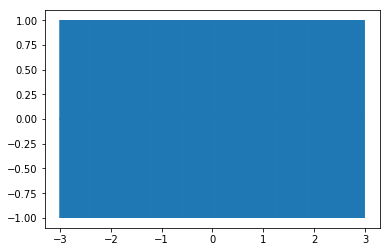

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

θ = [1, 10] # params - scaling factors
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
print(σ_0)

Now, we define the underlying function y which we will try to predict. We then take the first sample at an arbitrary point x = 1.0

In [3]:
x = [1.] # Make x float type

def f1(x):
    output = [np.sin(entry) for entry in x]
    return output

y = f1(x)
y

[0.8414709848078965]

Find out what predict() does?

In [4]:
# Update covariance matrix
σ_1 = exponential_cov(x, x, θ)

# predict(i, x, exponential_cov, θ, σ_2, y)
def predict(x, data_x, kernel, params, sigma, data_y):
    """
    x -> x_new, which are all points to be predicted on the plotted graph
    data -> all previous data points
    """
    k = [kernel(x, y, params) for y in data_x] # for each x_new, calculate covariance with all previous data points
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(data_y)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-5, 5, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]


In [5]:
print(σ_1)

[[ 1.]]


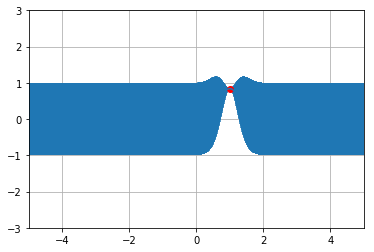

In [6]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

# Change settings of plot
plt.axis([-5, 5, -3, 3])
plt.grid(True)

In [7]:
# Add new datapoint x = 0.7 and recalculate 
x2 = [-0.7]
m2, s2 = conditional(x2, x, y, θ)

# y2 = np.random.normal(m2, s2)

y2 = f1(x2)

x.append(x2[0])

y.append(y2[0])

σ_2 = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]


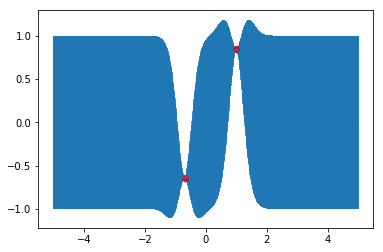

In [9]:
y_pred, sigmas = np.transpose(predictions)

plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)

plt.plot(x, y, "ro")


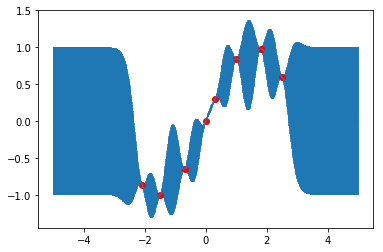

In [10]:
x_more = [-2.1, -1.5, 0.0, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
# y_more = np.random.multivariate_normal(mu, s)
y_more = f1(x_more)

x += x_more
# y += y_more.tolist()
y += y_more
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
